
# Bit Flip Error Correction Code levraging non locality and paralelism of Neutral Atoms hardware

 This tutorial introduces the bit flip error correction code using the Bloqade framework. We'll explore how to build and simulate a quantum circuit that encodes logical qubits, simulates noise, and corrects errors using the bit flip code.

Quantum systems are inherently fragile. Even small interactions with the environment can lead to errors in the quantum state. Quantum error correction (QEC) is a critical component of building reliable quantum computers. The bit flip code provides a simple yet powerful method to protect information against `X` (bit flip) errors.

### Why Neutral Atom Hardware?

Neutral atom platforms have emerged as a powerful and scalable approach to quantum computing. Atoms are trapped in optical tweezers and manipulated using laser fields, providing key advantages:

- **High connectivity**: Any pair of atoms can be entangled through Rydberg interactions, enabling efficient multi-qubit operations.
- **Scalability**: Arrays of hundreds of atoms can be created in a compact footprint, with reconfigurable geometry.
- **Long coherence times**: Neutral atoms have low sensitivity to environmental noise, supporting longer quantum operations.
- **Native multi-qubit gates**: The Rydberg blockade mechanism allows for direct implementation of controlled operations.

The **Bloqade** framework is specifically designed to simulate and compile programs for neutral atom devices, making it a natural choice for prototyping quantum error correction codes on this architecture.


In [2]:

from bloqade import qasm2

from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
from bloqade.pyqrack import PyQrack
from collections import Counter
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

from src.helper import get_qasm_string

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold


## Step 0: Before starting: a bit of theory

Unlike classical bits, quantum bits (qubits) are prone to both bit flips (X errors), phase flips (Z errors), and combinations thereof (Y errors). Measurement destroys quantum information, so we must find ways to **protect** and **recover** quantum states without collapsing them.

QEC encodes logical qubits across multiple physical qubits. The idea is to spread information redundantly so that individual errors can be detected and corrected using additional operations and ancilla qubits.

### Bit Flip Code Overview

The **bit flip code** is the simplest QEC code. It protects against a single `X` error (bit flip) by encoding one logical qubit into three physical qubits:

```
|0_L⟩ = |000⟩
|1_L⟩ = |111⟩
```

If a single qubit flips, the resulting state might be:
- |100⟩, |010⟩, or |001⟩ (from |000⟩)
- |011⟩, |101⟩, or |110⟩ (from |111⟩)

The error is corrected by applying a **majority vote**: we measure all three qubits and determine which value (0 or 1) is in the majority.

### Limitations

- Can only correct **one** bit flip error
- Cannot correct phase flip (`Z`) or combined (`Y`) errors
- Requires additional logic and qubits for **syndrome measurement**

Despite its simplicity, the bit flip code forms the foundation of more advanced error correction techniques like the **Shor code**, which combines both bit and phase flip correction.

## Step 1: Encode the logical qubit Using closest neighbor architecture 

In [3]:
@qasm2.extended
def swap_gate(q: qasm2.QReg, target1: int, target2: int):
    qasm2.cx(q[target1], q[target2])
    qasm2.cx(q[target2], q[target1])
    qasm2.cx(q[target1], q[target2])
    return q


In [4]:
@qasm2.extended
def create_bit_flip_circuit_CN():
    q = qasm2.qreg(5)
    c = qasm2.creg(5)
    # Prepare initial state with Hadamard
    qasm2.h(q[0])
    # Encode into three-qubit state
    qasm2.cx(q[0], q[1]) 
    swap_gate(q, 0, 1)
    qasm2.cx(q[1], q[2])  
    swap_gate(q, 0, 1)
 
    # Simulate bit-flip error on second qubit
    #qasm2.x(q[1])
    # first CNOT on the first ancillary qubit controled with the first qubit
    swap_gate(q, 0, 1)
    swap_gate(q, 1, 2)
    qasm2.cx(q[2], q[3])
    swap_gate(q, 1, 2)
    swap_gate(q, 0, 1)

    # second CNOT on the first ancillary qubit controled with the second qubit
    swap_gate(q, 1, 2)
    qasm2.cx(q[2], q[3])
    swap_gate(q, 1, 2)

    # third CNOT on the second ancillary qubit controled with the first qubit
    swap_gate(q, 0, 1)
    swap_gate(q, 1, 2)
    swap_gate(q, 2, 3)
    qasm2.cx(q[3], q[4])
    swap_gate(q, 2, 3)
    swap_gate(q, 1, 2)
    swap_gate(q, 0, 1)

    # fourth CNOT on the second ancillary qubit controled with the third qubit
    swap_gate(q, 1, 2)
    swap_gate(q, 2, 3)
    qasm2.cx(q[3], q[4])
    swap_gate(q, 2, 3)
    swap_gate(q, 1, 2)

    # Measure syndrome qubits
    qasm2.measure(q[3], c[3])  # First syndrome measurement
    qasm2.measure(q[4], c[4])  # Second syndrome measurement

    # Error correction based on syndrome (will be classical controlled)
    # Note: In real hardware, this would be controlled by classical measurement results
    #qasm2.x(q[1])  # Correct the error we introduced


    # Final measurement of the corrected qubit
    qasm2.measure(q[0], c[0])
    qasm2.measure(q[1], c[1])
    qasm2.measure(q[2], c[2])



    return c

In [5]:
target = QASM2()
ast = target.emit(create_bit_flip_circuit_CN)
pprint(ast)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
h q[0];
CX q[0], q[1];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[3], q[4];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[3], q[4];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
measure q[3] -> c[3];
measure q[4]

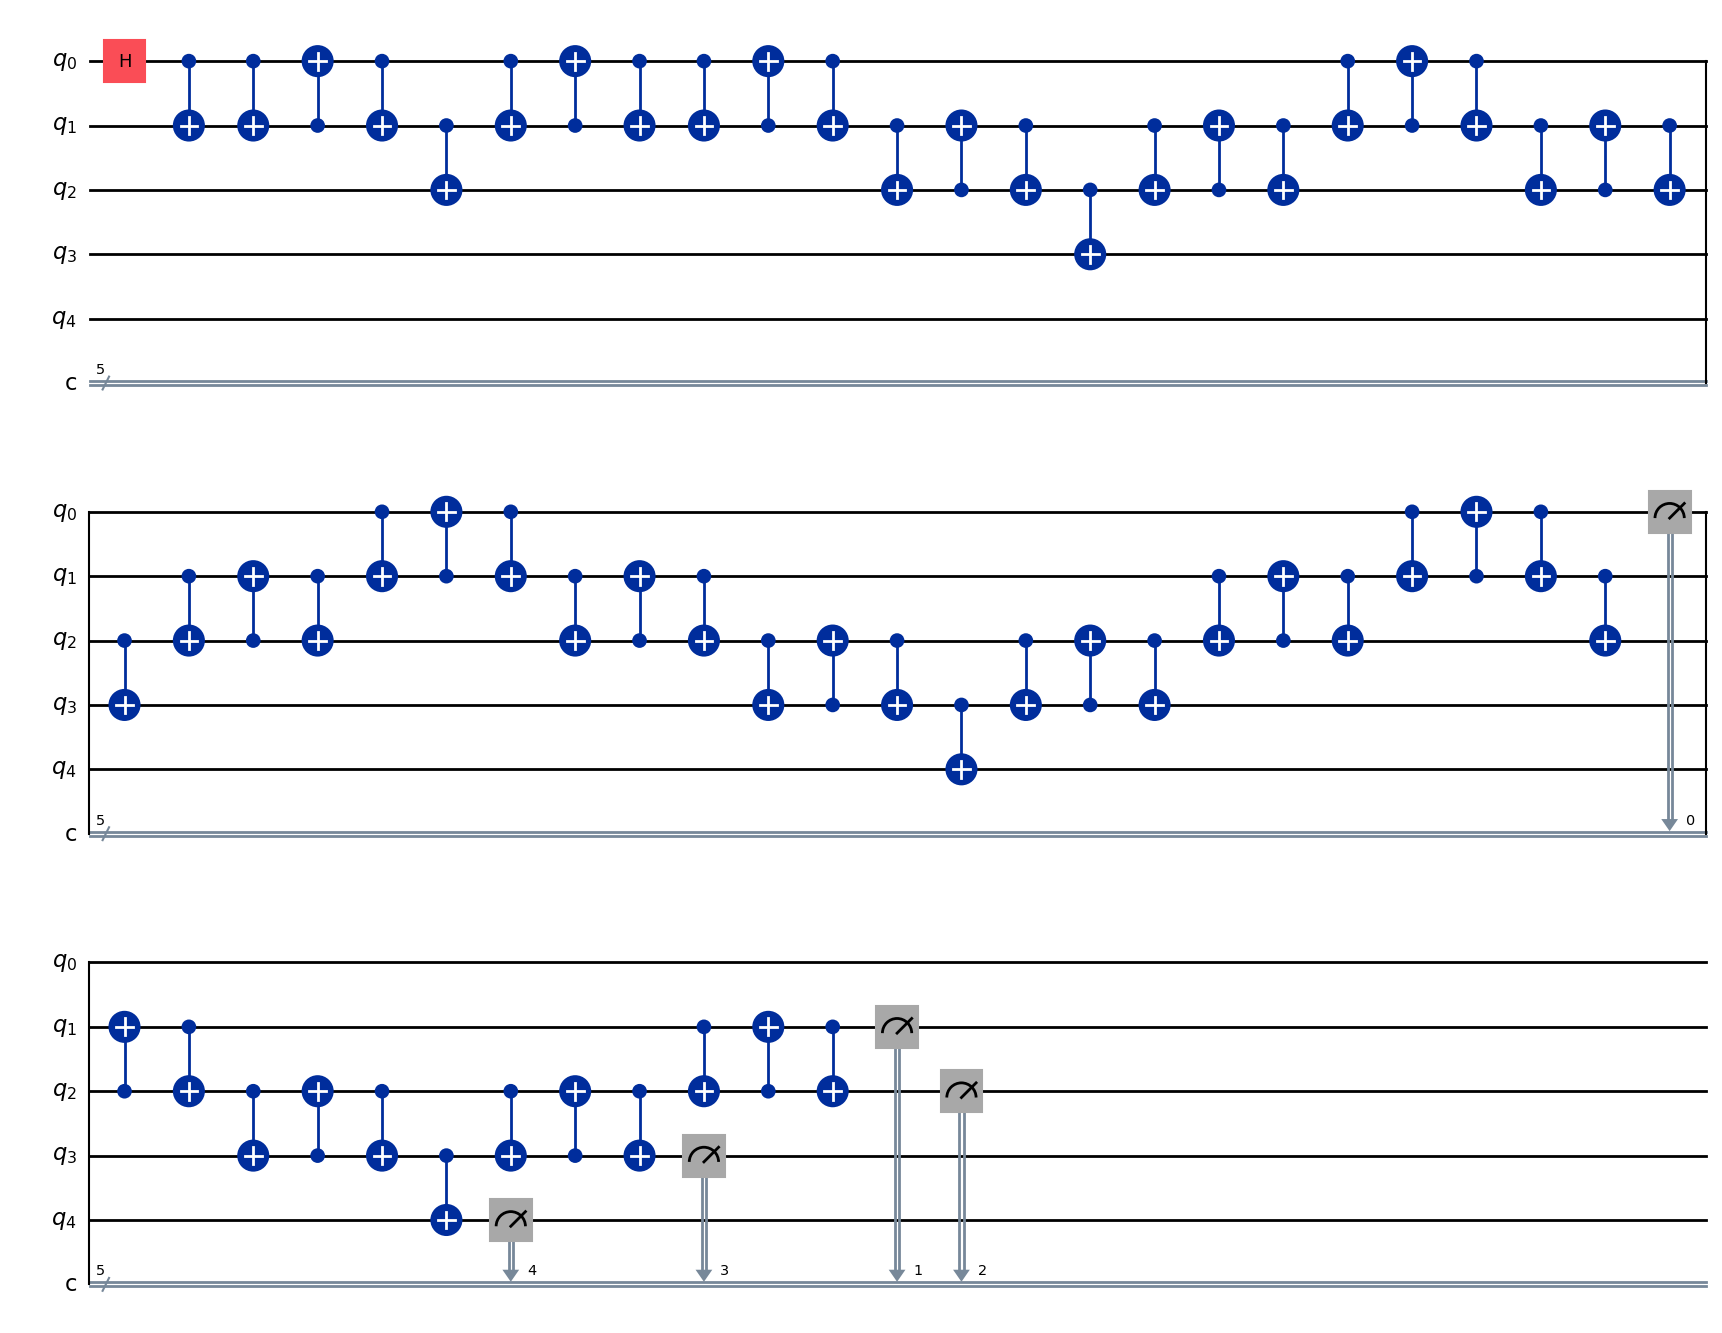

In [6]:
qasm_string = get_qasm_string(ast)
circuit = QuantumCircuit.from_qasm_str(qasm_string)
circuit.draw('mpl')

We implemented a vizualisation tool to represent the circuit. In this same occation we discover a minor naming bug in all the tutorials present in the website. Indeed, the quantum qubits register were called qreg, but this name is already resevered for adding qubit in bloqade. It was the source of some bugs when manipulating the circuits. 

The circuit is composed of 64 CNOT gates.

One final REALLY important note is that we could not implement the full circuit.

## Step 2: Constructing the same algorithm using the advantage of a neutral atoms hardware

In [7]:
@qasm2.extended
def create_bit_flip_circuit():
    q = qasm2.qreg(5)
    c = qasm2.creg(5)
    # Prepare initial state with Hadamard
    qasm2.h(q[0])
    # Encode into three-qubit state
    qasm2.cx(q[0], q[1])  # CNOT from qubit 0 to 1
    qasm2.cx(q[0], q[2])  # CNOT from qubit 0 to 2
    # Simulate bit-flip error on second qubit
    qasm2.x(q[1])
    # Add syndrome qubits and measure
    qasm2.cx(q[0], q[3])  # First syndrome
    qasm2.cx(q[1], q[3])
    qasm2.cx(q[0], q[4])  # Second syndrome
    qasm2.cx(q[2], q[4])
    # Measure syndrome qubits
    qasm2.measure(q[0], c[0])  # First syndrome measurement
    qasm2.measure(q[1], c[1])  # Second syndrome measurement
    # Measure all qubits
    qasm2.measure(q[2], c[2])
    qasm2.measure(q[3], c[3])
    qasm2.measure(q[4], c[4])

    return c

Using this architecture we only have 6 CNOTs gates.

## Step 3: Comparing the running time of both architecture, using a noiseless model

In [8]:
def runtime_comparison(shots_max: int, shots_step: int):
    import time
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    
    # Initialize lists to store timing data
    standard_times = []
    cn_times = []
    shot_counts = []
    
    # Run experiments for different shot counts
    for shots in range(100, shots_max, shots_step):
        # Time standard circuit
        start_time = time.time()
        results = device.multi_run(create_bit_flip_circuit, _shots=shots)
        execution_time = time.time() - start_time
        standard_times.append(execution_time)
        
        # Time CN circuit
        start_time = time.time()
        results_CN = device.multi_run(create_bit_flip_circuit_CN, _shots=shots)
        execution_time_CN = time.time() - start_time
        cn_times.append(execution_time_CN)
        
        shot_counts.append(shots)
        
        # Print timing results
        # print(f"\nStandard circuit with {shots} shots: {execution_time:.4f} seconds")
        # print(f"Closest Neighbor circuit with {shots} shots: {execution_time_CN:.4f} seconds")
        
        # # Get measurement counts
        # counts = to_bitstrings(results)
        # counts_CN = to_bitstrings(results_CN)
        
        
        # # Print measurement results
        # print("\nMeasurement results for standard circuit:")
        # for key, value in counts.items():
        #     print(f"{key}: {value}")
        # print("\nMeasurement results for CN circuit:")
        # for key, value in counts_CN.items():
        #     print(f"{key}: {value}")
        print("\nShot count:")
        print(shots)
# Create plot
    plt.figure(figsize=(12, 8))
    plt.plot(shot_counts, standard_times, 'bo-', label='Neutral Atom based Circuit', 
            markersize=8, linewidth=2)
    plt.plot(shot_counts, cn_times, 'ro-', label='Trapped Ion based Circuit',
            markersize=8, linewidth=2)
    
    # LaTeX formatting for labels
    plt.xlabel(r'Number of Shots ($N$)', fontsize=14)
    plt.ylabel(r'Execution Time (seconds)', fontsize=14)
    plt.title(r'Runtime Comparison of Different Quantum Circuits Architecture', fontsize=16)
    
    # Customize plot appearance
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, framealpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add minor ticks
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
time = runtime_comparison(5000, 500)


Shot count:
100

Shot count:
600

Shot count:
1100


## Step 4: Adding noise to the measurment 

In [ ]:
@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass

In [ ]:
# add noise
noise_kernel = create_bit_flip_circuit_CN.similar()
extended_opt.run_pass(noise_kernel, parallelize=True)
NoisePass(extended_opt)(noise_kernel)

noise_kernel = noise_kernel.similar(extended_opt.add(native))


In [ ]:
def to_bitstrings(results):
    return Counter(map(lambda result:"".join(map(str, result)), results))

In [ ]:
device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
results = device.multi_run(noise_kernel, _shots=(800))


counts = to_bitstrings(results)

for key, value in counts.items():
    print(key, value)


## Conclusion

We have demonstrated how the **bit flip code** can detect and correct a single bit-flip error. By encoding the logical qubit into three physical qubits and using majority voting, we can recover the original state even if one of the qubits experiences an error.
